In [18]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import sklearn.metrics as sm
import sys
import os
import datetime
from skimage import img_as_uint
from skimage.filters import threshold_otsu, threshold_niblack
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
import pandas as pd
import shutil


plt.rcParams.update({'font.size': 6})
mpl.rcParams['figure.dpi'] = 300
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname("__file__"))))
aois = 6
training_date = '1629037296'
if aois ==2 :
    aoi = 'AOI_2_Vegas'
elif aois == 3: 
    aoi = 'AOI_3_Paris'
elif aois == 4: 
    aoi = 'AOI_4_Shanghai'
elif aois==5 :
    aoi = 'AOI_5_Khartoum'
elif aois==6 :
    aoi = 'Urban3D'
elif aois==7 :
    aoi = 'WHU'

im_dir = '../data/Test/' + aoi + '_Test/'
pred_top_dir = '../result/' 



In [19]:
def revision_metric(gt, pred):
    gt = gt.ravel().astype(int)
    pred = pred.ravel().astype(int)
    accuracy_ = sm.accuracy_score(gt, pred)
    bal_accu = sm.jaccard_score(gt, pred)
    f1_score = sm.f1_score(gt, pred)
    recall = sm.recall_score(gt, pred)
    precision = sm.precision_score(gt, pred)
    
    return accuracy_, f1_score, recall, precision, bal_accu


In [20]:
#get mask from infered image

infer_dir = os.path.join(pred_top_dir+ 'infer'+ '/'+ aoi + '_' + training_date)
out_dir_mask = os.path.join(pred_top_dir+ 'infer_masks'+ '/' +aoi  +'_' + training_date)
print(infer_dir)
print(out_dir_mask)
if os.path.isdir(out_dir_mask) :
    shutil.rmtree(out_dir_mask)
    os.makedirs(out_dir_mask, exist_ok=True)
else : 
    os.makedirs(out_dir_mask, exist_ok=True)
im_list = sorted([z for z in os.listdir(infer_dir) if z.endswith('.tif')])
for i,j in enumerate(im_list):
    name_root = j.split('.')[0]
    image_path = os.path.join(infer_dir,name_root+'.tif')
    mask_path = os.path.join(out_dir_mask,name_root+'.tif')
    mask_image = skimage.io.imread(image_path)
    
    binary = mask_image > 0

    skimage.io.imsave(mask_path, binary)


../result/infer/Urban3D_1629037296
../result/infer_masks/Urban3D_1629037296


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: ../result/infer_masks/Urban3D_1629037296/_10_RIC_Tile_000_RGB.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: ../result/infer_masks/Urban3D_1629037296/_10_RIC_Tile_000_RGB.tif is a low contrast image
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: ../result/infer_masks/Urban3D_1629037296/_10_RIC_Tile_001_RGB.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: ../result/infer_masks/Urban3D_1629037296/_10_RIC_Tile_001_RGB.tif is a low contrast image
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: ../result/infer_masks/Urban3D_1629037296/_10_R

../result/infer/Urban3D_1629037296/_10_RIC_Tile_092_RGB.tif
../result/infer_masks/Urban3D_1629037296/_10_RIC_Tile_092_RGB.tif


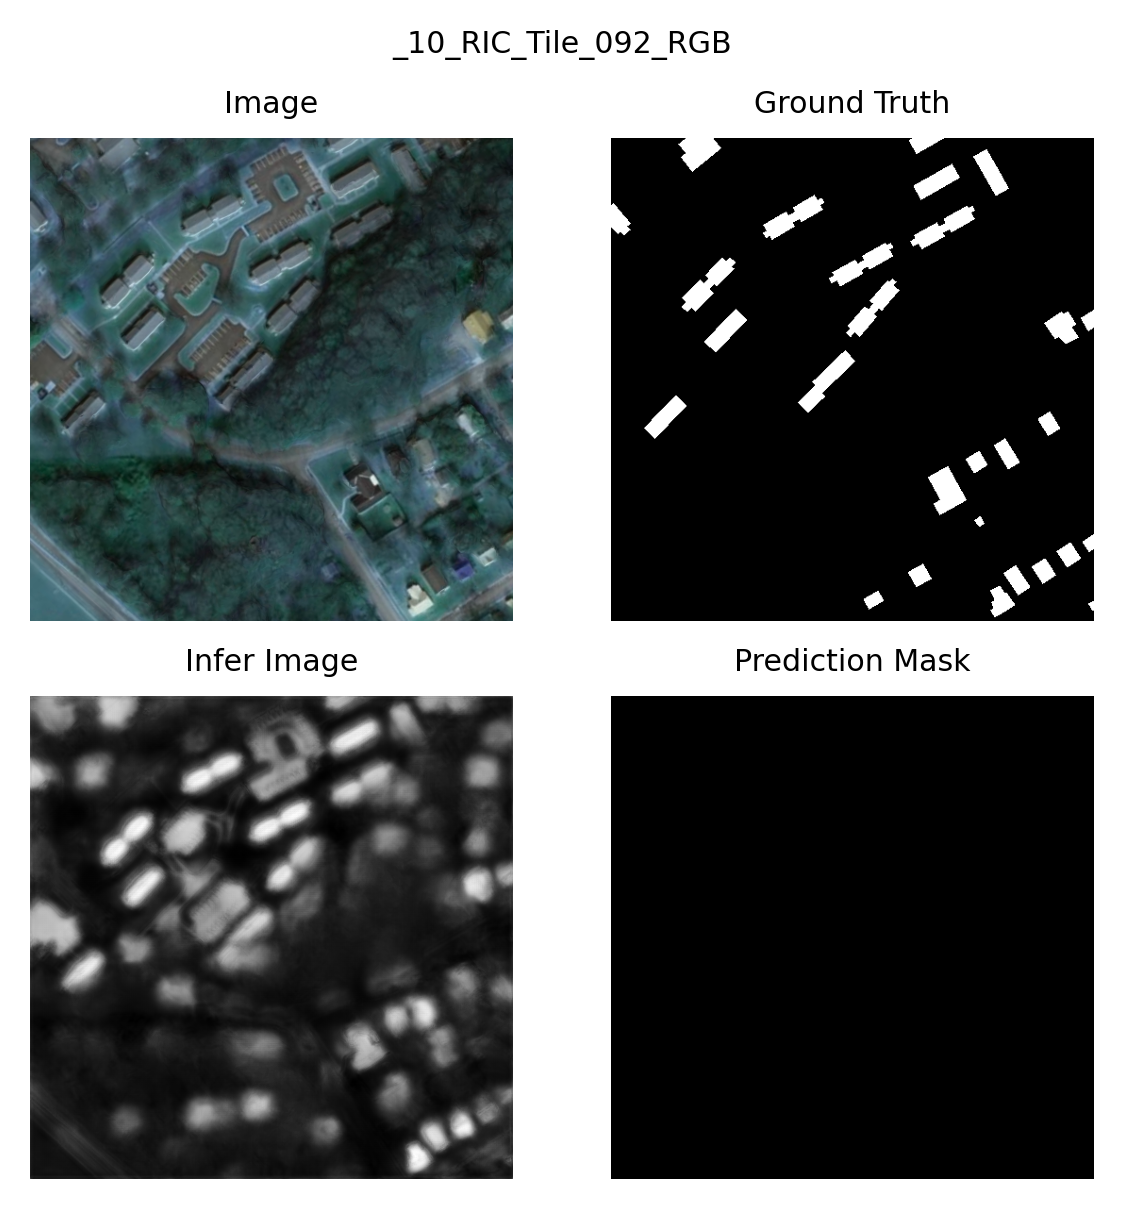

In [21]:
#compare target, ground truth, prediction
import skimage
import skimage.segmentation
import copy

im_list = sorted([z for z in os.listdir(os.path.join(im_dir,'RGB')) if z.endswith('.tif')])
sample_name= im_list[25]

gt_path = os.path.join(im_dir, 'masks', sample_name).replace('RGB','GTL')
image_pt = os.path.join(im_dir, 'RGB', sample_name)
infer_path = os.path.join(infer_dir+ '/'+ sample_name)
prediction_path = os.path.join(out_dir_mask+ '/'+ sample_name)

print(infer_path)
print(prediction_path)
img = cv2.imread(image_pt,cv2.IMREAD_UNCHANGED )
img = img.astype(np.uint16)
gt_image = skimage.io.imread(gt_path)
infer_image = skimage.io.imread(infer_path)
infer_image = np.squeeze(infer_image.transpose(2,3,1,0),axis=2)
mask_image = skimage.io.imread(prediction_path)
mask_image = np.squeeze(mask_image.transpose(2,3,1,0),axis=2)
boundary = skimage.segmentation.find_boundaries(binary, mode='inner', background=0).astype(np.float32)
boundary=boundary*255

fig = plt.figure(figsize=(4,4))
rows=2
cols=2
ax0 = fig.add_subplot(rows, cols, 1)
ax1 = fig.add_subplot(rows, cols, 2)
ax2 = fig.add_subplot(rows, cols, 3)
ax3 = fig.add_subplot(rows, cols, 4)
ax0.imshow(img)
# ax0.imshow(infer_image,cmap='gray')
ax0.axis('off')
ax0.set_title('Image')
ax1.imshow(gt_image,cmap='gray')
ax1.axis('off')
ax1.set_title('Ground Truth')
ax2.imshow(infer_image,cmap='gray')
ax2.axis('off')
ax2.set_title('Infer Image')
ax3.imshow(mask_image,cmap='gray')
ax3.axis('off')
ax3.set_title('Prediction Mask')
plt.suptitle(sample_name.split('.')[0])
plt.tight_layout()
plt.show()



In [22]:
def average(list):
    return (sum(list) / len(list))

eval_path = os.path.join(pred_top_dir+'eval_result'+'/'+aoi+'_'+training_date)
os.makedirs(eval_path, exist_ok=True)
gt_list= sorted([z for z in os.listdir(os.path.join(im_dir,'masks')) if z.endswith('.tif')])
print("list_len : ", len(gt_list))
eval_list = []
mask_list=[]
acc_list=[]
f1_list = []
rec_list = []
prec_list = []
bal_acc_list=[]
for i,j in enumerate(gt_list) : 
    mask_name = j.split('.')[0]

    gt_array = skimage.io.imread(os.path.join(im_dir, 'masks',mask_name+'.tif'))
    eval_mask = os.path.join(out_dir_mask+ '/'+mask_name+'.tif').replace('GTL','RGB')
    mask_array = skimage.io.imread(eval_mask)
    eval_result = revision_metric(gt_array/255., mask_array/255.)
    acc_list.append(eval_result[0])
    f1_list.append(eval_result[1])
    rec_list.append(eval_result[2])
    prec_list.append(eval_result[3])
    bal_acc_list.append(eval_result[4])
acc_list_nonzero = [i for i in acc_list if i > 0 ] 
f1_list_nonzero = [i for i in f1_list if i > 0 ]    
rec_list_nonzero = [i for i in rec_list if i > 0 ]    
prec_list_nonzero = [i for i in prec_list if i > 0 ]  
bal_acc_list_nonzero = [i for i in bal_acc_list if i > 0 ]  
a=round(average(acc_list_nonzero),5)
b=round(average(prec_list_nonzero),5)
c=round(average(rec_list_nonzero),5)
d=round(average(f1_list_nonzero),5)
e= round(average(bal_acc_list_nonzero),5)

print("accuray = %.5f" % a)
print("precision = %.5f" % b)
print("recall = %.5f" % c)
print("f1_score = %.5f" % d)

eval_df = pd.DataFrame(columns=['file_name','accuracy',  'precision', 'recall', 'f1_score','bal_accuracy'])
eval_df.loc[0] = ("Average",a,b,c,d,e)
eval_result = pd.DataFrame([x for x in zip(gt_list,acc_list, prec_list, rec_list, f1_list,bal_acc_list )], columns=['file_name','accuracy',  'precision', 'recall', 'f1_score', 'bal_accuracy'])    
evaldf = eval_df.append(eval_result)

evaldf.to_csv(eval_path+"_eval_result.csv",mode='w')
evaldf

list_len :  672


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to 

accuray = 0.13257
precision = 0.13257
recall = 1.00000
f1_score = 0.22175


,file_name,accuracy,precision,recall,f1_score,bal_accuracy
0,Average,0.132570,0.132570,1.0,0.221750,0.132570
0,_10_RIC_Tile_000_GTL.tif,0.287952,0.287952,1.0,0.447148,0.287952
1,_10_RIC_Tile_001_GTL.tif,0.195366,0.195366,1.0,0.326872,0.195366
2,_10_RIC_Tile_002_GTL.tif,0.020363,0.020363,1.0,0.039913,0.020363
3,_10_RIC_Tile_013_GTL.tif,0.251091,0.251091,1.0,0.401395,0.251091
...,...,...,...,...,...,...
667,_9_RIC_Tile_125_GTL.tif,0.035389,0.035389,1.0,0.068359,0.035389
668,_9_RIC_Tile_128_GTL.tif,0.050064,0.050064,1.0,0.095354,0.050064
669,_9_RIC_Tile_129_GTL.tif,0.034779,0.034779,1.0,0.067219,0.034779
670,_9_RIC_Tile_133_GTL.tif,0.064632,0.064632,1.0,0.121417,0.064632
